# Imports

In [8]:
!pip install chess
!pip install tensorflow

In [1]:
from keras.layers import Input, Concatenate, LSTM, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizer_v2.adam import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import ast
from IPython.display import clear_output

import chess.pgn

# Data Preparation

In [2]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

## ECO Openings sequences

In [3]:
import csv
import collections

openings = collections.defaultdict(list)

with open('openings.csv', mode='r') as infile:
    reader = csv.reader(infile)
    headers = next(reader)
    for rows in reader:
        move = " ".join(ast.literal_eval(rows[3]))
        openings[rows[2]].append(move)

## Functions used in dynamic representation

In [4]:
def get_mid_game(game):
    mean = 0
    eco_code = game.headers["ECO"]
    move_sequence = str(game.mainline_moves()).replace(". ", ".")
    for move in openings[eco_code]:
        mean += len(move.split(" "))
        if move in move_sequence:
            return len(move.split(" "))
    if len(openings[eco_code]) > 0:
        return mean // len(openings[eco_code])
    else:
        return 0

In [5]:
def get_end_game(game, theory):
    board = chess.Board()
    count = 0
    pieces = ['r', 'n', 'b', 'q']
    if theory == "minev":
        # For each move
        for move in game.mainline_moves():
            board.push(move)
            pieces_count = 0
            # Coun how many pieces different from pawns and kings
            for p in pieces:
                pieces_count += str(board).count(p)
                pieces_count += str(board).count(p.capitalize())
            # If that number is less or equal to 4 return the number of moves to get to end game
            if pieces_count <= 4:
                return count
            count += 1
    elif theory == "flear":
        for move in game.mainline_moves():
            board.push(move)
            pieces_count_w = 0
            pieces_count_b = 0
            # Coun how many pieces different from pawns and kings
            for p in pieces:
                pieces_count_b += str(board).count(p)
                pieces_count_w += str(board).count(p.capitalize())
            # If that number is less or equal to 4 return the number of moves to get to end game
            if pieces_count_b <= 1 and pieces_count_w <= 1:
                return count
            count += 1
    elif theory == "fine":
        for move in game.mainline_moves():
            board.push(move)
            if (not "q" in str(board)) and (not "Q" in str(board)):
                return count
            count += 1
    return 1000

In [6]:
def get_pawns(board_list):
    black_pawns = []
    white_pawns = []
    # get all positions of pawns
    for i, line in enumerate(board_list):
        for j, tile in enumerate(line):
            if tile == "p":
                black_pawns.append((i, j))
            if tile == "P":
                white_pawns.append((i, j))
    return (black_pawns, white_pawns)

In [7]:
def get_passed_pawns(pawns):
    black_pawns, white_pawns = pawns
    passed_pawns = black_pawns + white_pawns
    for bp in black_pawns:
        for wp in white_pawns:
            if bp[0] < wp[0]:
                if bp[1] - 1 == wp[1] or bp[1] + 1 == wp[1] or bp[1] == wp[1]:
                    passed_pawns.remove(bp)
                    break

    for wp in white_pawns:
        for bp in black_pawns:
            if wp[0] > bp[0]:
                if bp[1] == wp[1] - 1 or bp[1] == wp[1] + 1 or bp[1] == wp[1]:
                    passed_pawns.remove(wp)
                    break
    return passed_pawns

In [8]:
def get_isolated_pawns(pawns):
    black_pawns, white_pawns = pawns
    isolated_pawns = black_pawns + white_pawns
    for p in black_pawns:
        for bp in black_pawns:
            if p != bp:
                if p[1] - 1 == bp[1] or p[1] + 1 == bp[1]:
                    isolated_pawns.remove(p)
                    break
    for p in white_pawns:
        for wp in white_pawns:
            if p != wp:
                if p[1] - 1 == wp[1] or p[1] + 1 == wp[1]:
                    isolated_pawns.remove(p)
                    break

    return isolated_pawns

In [9]:
def handle_dynamic(game, game_size, end):
    single_game = []
    cost = [1, 3.05, 3.33, 5.63, 9.5, 10, 1, 3.05, 3.33, 5.63, 9.5, 10]
    lex = ["P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"]
    non_passed = [[1, 1, 1, 1, 1, 1, 1, 1],
                  [0.90, 0.95, 1.05, 1.10, 1.10, 1.05, 0.95, 0.90],
                  [0.90, 0.95, 1.05, 1.15, 1.15, 1.05, 0.95, 0.90],
                  [0.90, 0.95, 1.10, 1.20, 1.20, 1.10, 0.95, 0.90],
                  [0.97, 1.03, 1.17, 1.27, 1.27, 1.17, 1.03, 0.97],
                  [1.06, 1.12, 1.25, 1.40, 1.40, 1.25, 1.12, 1.06],
                  [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]
    isolated = [1, 1, 1, 1.05, 1.30, 2.1, 1, 1]
    connected = [1, 1, 1, 1.15, 1.35, 2.1, 1, 1]
    passed = [1, 1, 1, 1.30, 1.55, 2.1, 1, 1]
    passed_connected = [1, 1, 1, 1.55, 2.3, 3.5, 1, 1]

    midgame = get_mid_game(game) + 1
    endgame = get_end_game(game, theory=end)
    board = chess.Board()

    for n, move in enumerate(game.mainline_moves()):

        if n == midgame:
            non_passed = np.ones((8, 8))
        elif n == endgame:
            non_passed = [[1, 1, 1, 1, 1, 1, 1, 1],
                          [1.20, 1.05, 0.95, 0.90, 0.90, 0.95, 1.05, 1.20],
                          [1.20, 1.05, 0.95, 0.90, 0.90, 0.95, 1.05, 1.20],
                          [1.25, 1.10, 1.00, 0.95, 0.95, 1.00, 1.10, 1.25],
                          [1.33, 1.17, 1.07, 1.00, 1.00, 1.07, 1.17, 1.33],
                          [1.45, 1.29, 1.16, 1.05, 1.05, 1.16, 1.29, 1.45],
                          [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]

        board.push(move)
        board_list = str(board).replace(" ", "").split("\n")
        pawns = get_pawns(board_list)
        # gives a list of passed pawns
        passed_pawns = get_passed_pawns(pawns)
        # gives a list of isolated pawns
        isolated_pawns = get_isolated_pawns(pawns)
        # gives a list of connected pawns
        connected_pawns = connected_pawns = [
            x for x in pawns[0] + pawns[1] if x not in isolated_pawns
        ]
        vec = [np.zeros((8, 8)) for i in range(12)]
        for line_pos in range(8):
            for col_pos in range(8):
                piece = board_list[line_pos][col_pos]
                if piece in lex:
                    lex_pos = lex.index(piece)
                    value = cost[lex_pos]
                    multiplier = 1

                    # If pawn is white, rank is inverted
                    if piece == "p":
                        rank = line_pos
                    elif piece == "P":
                        rank = -(line_pos + 1)

                    if piece == "p" or piece == "P":
                        if (line_pos, col_pos) not in passed_pawns:
                            value = non_passed[rank][col_pos]
                        if (line_pos, col_pos) in passed_pawns and (
                                line_pos, col_pos) in connected_pawns:
                            multiplier *= passed_connected[rank]
                        elif (line_pos, col_pos) in passed_pawns:
                            multiplier *= passed[rank]
                        elif (line_pos, col_pos) in connected_pawns:
                            multiplier *= connected[rank]
                        if (line_pos, col_pos) in isolated_pawns:
                            multiplier *= isolated[rank]

                    # Assign a value according to the piece position and a multiplier
                    vec[lex_pos][line_pos][col_pos] = value * multiplier
        single_game.append(np.asarray(vec))
        if n == game_size - 1:
            break

    if n < game_size - 1:
        for i in range(game_size - n - 1):
            single_game.append([np.zeros((8, 8)) for i in range(12)])
    return np.asarray(single_game)

## Convert PGN to bitmap/algebraic/alphazero/dynamic representation

In [10]:
""" Allows to convert a PGN file into bitmap/algebraic/alphazero/dynamic representation """


def convert_pgn(PGN_FILE,
                data_type="bitmap",
                game_size=80,
                max_amount=100,
                start_at=0,
                endgame="minev"):
    data = []
    target = []
    names = []
    elos = []
    lex = ["P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"]
    if data_type == "algebraic":
        cost = [1, 3, 3, 5, 9, 10, 1, 3, 3, 5, 9, 10]
    elif data_type == "bitmap":
        cost = [1 for i in range(12)]
    elif data_type == "alphazero":
        cost = [1, 3.05, 3.33, 5.63, 9.5, 10, 1, 3.05, 3.33, 5.63, 9.5, 10]
    amount = 0
    with open(PGN_FILE) as f:
        game = 0
        #Parse each game
        while True:
            game = chess.pgn.read_game(f)
            if amount >= start_at:
                clear_output(wait=True)
                print(amount, flush=True)
                move_count = 0
                #Avoid the last element
                if game is None:
                    break

                #Get the result of the game
                score = game.headers["Result"]
                if score.startswith("1-0"):
                    target.append(0)
                elif score.startswith("0-1"):
                    target.append(1)
                else:
                    target.append(2)

                #Get the names
                names.append([game.headers["White"], game.headers["Black"]])

                #Get ELO rankings
                elos.append([
                    int(game.headers["WhiteElo"]),
                    int(game.headers["BlackElo"])
                ])

                # DYNAMIC DATATYPE PART
                if data_type == "dynamic":
                    data.append(
                        handle_dynamic(game, game_size=game_size, end=endgame))
                else:
                    #Actual game
                    single_game = []
                    board = chess.Board()

                    #Parse each move
                    for move in game.mainline_moves():
                        move_count += 1
                        vec = [np.zeros((8, 8)) for i in range(12)]
                        board.push(move)
                        board_list = str(board).replace(" ", "").split("\n")
                        for line_pos in range(8):
                            for col_pos in range(8):
                                if board_list[line_pos][col_pos] in lex:
                                    lex_pos = lex.index(
                                        board_list[line_pos][col_pos])
                                    vec[lex_pos][line_pos][col_pos] = cost[
                                        lex_pos]
                        single_game.append(np.asarray(vec))
                        #Not exceed game size
                        if move_count == game_size:
                            break
                    #If it doesn't reach the game size, fill with 0
                    if move_count < game_size:
                        for i in range(game_size - move_count):
                            single_game.append(
                                [np.zeros((8, 8)) for i in range(12)])

                    single_game = np.asarray(single_game)
                    data.append(single_game)

            amount += 1
            if amount == max_amount + start_at:
                break

        # Reshape datas to fit the model
        data = [[y.reshape(768, ) for y in x] for x in data]
        # Normalisation
        data = np.asarray(data)
        # Count White wins, Black wins and Draws
        target = np.array(target, dtype=int)
        unique, counts = np.unique(target, return_counts=True)
        amount = amount - start_at
        print(f"{amount} games converted to {data_type}.")
        print(
            f"{round(counts[0]/amount*100, 2)}% White wins, {round(counts[1]/amount*100, 2)}% Black wins, {round(counts[2]/amount*100, 2)}% Draws."
        )
        # Convert game results to categorical data
        target = keras.utils.to_categorical(target, num_classes=3)
        names = np.asarray(names)
        elos = np.asarray(elos)

    return (data, target, names, elos)

# Dataset

In [11]:
SEQ_LENGTH = 80
AMOUNT = 30000

In [12]:
content, target, names, elos = convert_pgn("KingBase2018-B20-B49.pgn", max_amount=AMOUNT, data_type="algebraic", game_size=SEQ_LENGTH)

29999
30000 games converted to algebraic.
36.06% White wins, 31.46% Black wins, 32.48% Draws.


In [13]:
print(content.shape, target.shape, names.shape, elos.shape)

(30000, 80, 768) (30000, 3) (30000, 2) (30000, 2)


In [14]:
# Categorize names
label_encoder = LabelEncoder()
# Reshape into 1D
names_cat = names.reshape(AMOUNT*2)
# Categorize
names_cat = np.array(label_encoder.fit_transform(names_cat))
names_cat = names_cat.astype('float64')
# Reshape into (AMOUNT, 2)
names_cat = names_cat.reshape((AMOUNT, 2))
names_cat = NormalizeData(names_cat)

In [15]:
elos_norm = NormalizeData(elos)

In [16]:
# context = np.concatenate((names_cat, elos_norm), axis=1)
context = np.array([[names_cat[i][0], elos_norm[i][0], names_cat[i][1], elos_norm[i][1]] for i in range(len(names_cat))])

In [19]:
x1_train, x1_rem, x2_train, x2_rem, y_train, y_rem = train_test_split(content, context, target, train_size = 0.6, random_state = 4)

In [21]:
x1_test, x1_val, x2_test, x2_val, y_test, y_val = train_test_split(x1_rem, x2_rem, y_rem, test_size = 0.5, random_state = 4)

In [23]:
print(x1_train.shape, x1_test.shape, x1_val.shape)
print(x2_train.shape, x2_test.shape, x2_val.shape)

(18000, 80, 768) (6000, 80, 768) (6000, 80, 768)
(18000, 4) (6000, 4) (6000, 4)


# Model

In [25]:
content_input = Input((80, 768))
context_input = Input((4))

x = LSTM(512, activation="tanh", return_sequences=True)(content_input)
x = Dropout(.2)(x)
x = LSTM(256, activation="tanh", return_sequences=True)(x)
x = Dropout(.2)(x)
x = LSTM(128, activation="tanh", dropout=0.2, return_sequences=False)(x)

y = Dense(4, activation="relu")(context_input)
y = Dropout(.2)(y)
y = Dense(16, activation="relu")(y)
y = Dropout(.2)(y)
y = Dense(12, activation="relu")(y)
y = Dropout(.2)(y)
y = Dense(8, activation="relu")(y)
# Not sure
# y = Dropout(.2)(y)
y = Flatten()(y)

concat_layer = Concatenate()([x, y])
output = Dense(64, activation="relu")(concat_layer)
output = Dense(3, activation="softmax")(output)

model = Model(inputs=[content_input, context_input], outputs=output)
# Optimizer
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, amsgrad=False)

# Early Stopping
early_stopping = EarlyStopping(patience=5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 4)            20          ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4)            0           ['dense[0][0]']                  
                                                                                                  
 input_1 (InputLayer)           [(None, 80, 768)]    0           []                               
                                                                                              

## Structure

In [3]:
!pip install pydot

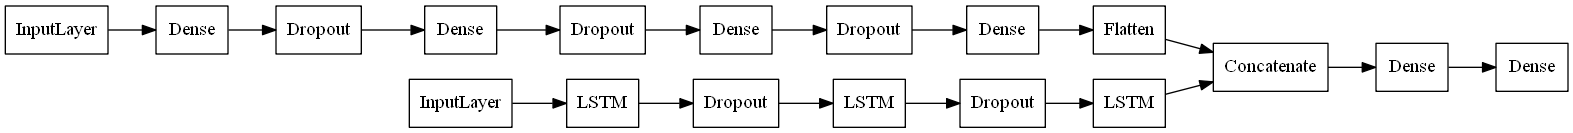

In [27]:
plot_model(model, show_shapes=False, show_layer_names=False, rankdir='LR', to_file='model.png')

# Training

In [26]:
history = model.fit(x=[x1_train, x2_train],
                    y=y_train,
                    validation_data=([x1_val, x2_val], y_val),
                    epochs=80,
                    callbacks=[early_stopping])

Epoch 1/80
563/563 [==============================] - 524s 924ms/step - loss: 1.0756 - accuracy: 0.4056 - val_loss: 1.0285 - val_accuracy: 0.4790
Epoch 2/80
563/563 [==============================] - 529s 940ms/step - loss: 0.9796 - accuracy: 0.5210 - val_loss: 0.9072 - val_accuracy: 0.5743
Epoch 3/80
563/563 [==============================] - 535s 951ms/step - loss: 0.8653 - accuracy: 0.6053 - val_loss: 0.8947 - val_accuracy: 0.5740
Epoch 4/80
563/563 [==============================] - 536s 951ms/step - loss: 0.7247 - accuracy: 0.6903 - val_loss: 0.9160 - val_accuracy: 0.5813
Epoch 5/80
563/563 [==============================] - 533s 947ms/step - loss: 0.5019 - accuracy: 0.8092 - val_loss: 1.1104 - val_accuracy: 0.5592
Epoch 6/80
563/563 [==============================] - 538s 957ms/step - loss: 0.3027 - accuracy: 0.8938 - val_loss: 1.3941 - val_accuracy: 0.5570
Epoch 7/80
563/563 [==============================] - 545s 968ms/step - loss: 0.1854 - accuracy: 0.9391 - val_loss: 1.5537 -

# Results

In [27]:
score = model.evaluate([x1_test, x2_test], y_test)

188/188 [==============================] - 57s 305ms/step - loss: 1.7976 - accuracy: 0.5543


In [28]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[1.7975819110870361, 0.5543333292007446]


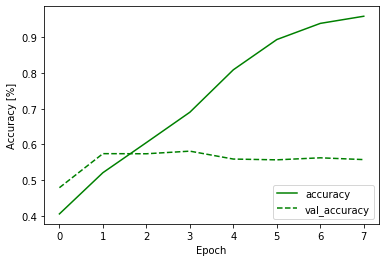

In [29]:
plt.plot(history.history['accuracy'], 'g')
plt.plot(history.history['val_accuracy'], 'g--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.legend(["accuracy", "val_accuracy"], loc ="lower right") 

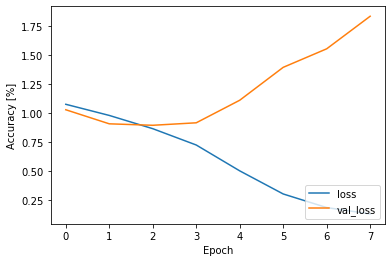

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.legend(["loss", "val_loss"], loc ="lower right") 